In [20]:
### Perceptron ###

import numpy as np

class Perceptron:
    """Perceptron
    
    Parameters
    ----------
    eta : float
    Learning rate (0.0 to 1.0)

    n_iter : int
    epochs, or passes over training set

    random_state: int
    random number generator

    Attributes
    ----------

    w_ : 1d-array
    weights after fitting
    
    b_ : Scalar
    bias unit after fitting

    errors_ : list
    Number of misclassifications (updates) in each epoch.
    
    """
    def __init__ (self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """
        Fit training data

        X : array-like, shape = [ n_examples, n_features ]
        n_examples - number of examples
        n_features - number of features

        y : shape = [ n_examples ]
        Target Values

        Returns
        --------

        self : object

        """
        rgen = np.random.RandomState( self.random_state )
        self.w_ = rgen.normal( loc=0.0, scale=0.01, size=X.shape[1])

        self.b_ = np.float_(0.)
        self.errors_ = []

        for _ in range (self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi) )
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)
            self.errors_.append( errors )
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot( X, self.w_) + self.b_
    
    def predict( self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)

In [21]:
import os
import pandas as pd

s = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

print('From URL:', s)

df = pd.read_csv(s, header=None, encoding='utf-8')

df.tail()

From URL: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


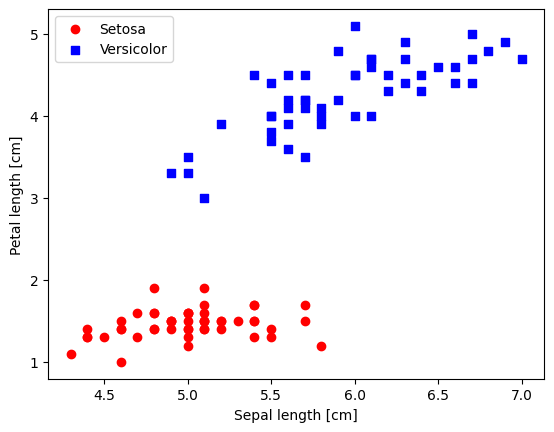

In [22]:
import matplotlib.pyplot as plt

# select setosa and versicolor
y = df.iloc[0:100, 4].values
y = np.where( y == 'Iris-setosa', 0, 1)
# extract sepal length and petal length
X = df.iloc[0:100, [0,2]].values
# plot data
plt.scatter(X[:50, 0], X[:50, 1], color='red', marker='o', label='Setosa')
plt.scatter( X[50:100, 0], X[50:100, 1], color='blue', marker='s', label='Versicolor')
plt.xlabel('Sepal length [cm]')
plt.ylabel('Petal length [cm]')
plt.legend(loc='upper left')
plt.show()

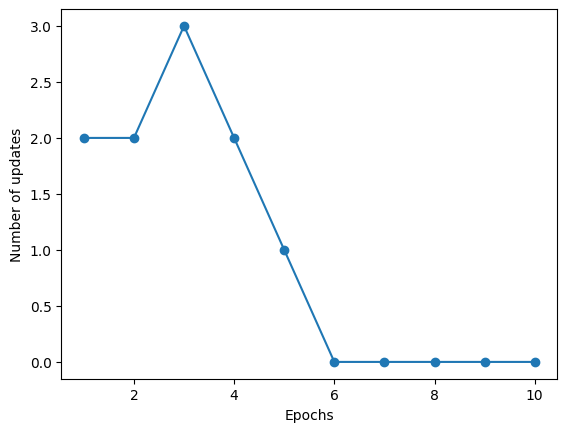

In [23]:
ppn = Perceptron(eta=0.1, n_iter=10)
ppn.fit(X, y)

plt.plot( range(1, len(ppn.errors_) + 1 ), ppn.errors_, marker='o' )
plt.xlabel('Epochs')
plt.ylabel('Number of updates')
plt.show()

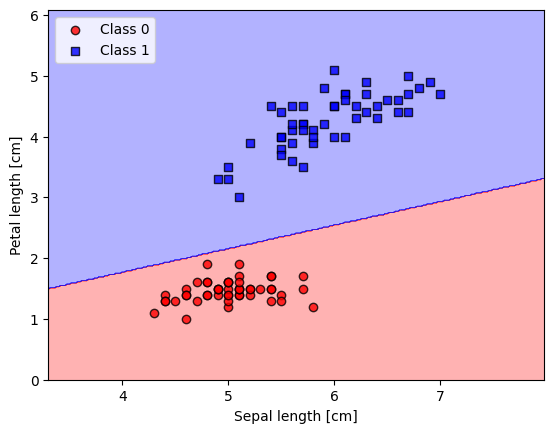

In [24]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ( 'o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid( np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict( np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter( x=X[y == cl, 0],
                     y=X[y == cl, 1],
                     alpha=0.8,
                     c=colors[idx],
                     marker=markers[idx],
                     label=f'Class {cl}',
                     edgecolor='black')
        
plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('Sepal length [cm]')
plt.ylabel('Petal length [cm]')
plt.legend(loc='upper left')

plt.show()


In [30]:
### Adaline ###

import numpy as np

class AdalineGD:
    """ADAptive LInear NEuron classifier
    
    Parameters
    ----------
    eta : float
    Learning rate (0.0 to 1.0)

    n_iter : int
    epochs, or passes over training set

    random_state: int
    random number generator

    Attributes
    ----------

    w_ : 1d-array
    weights after fitting
    
    b_ : Scalar
    bias unit after fitting

    losses_ : list
    Mean squared error loss function values in each epoch.
    
    """
    def __init__ (self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """
        Fit training data

        X : array-like, shape = [ n_examples, n_features ]
        n_examples - number of examples
        n_features - number of features

        y : shape = [ n_examples ]
        Target Values

        Returns
        --------

        self : object

        """
        rgen = np.random.RandomState( self.random_state )
        self.w_ = rgen.normal( loc=0.0, scale=0.01, size=X.shape[1])

        self.b_ = np.float_(0.)
        self.losses_ = []

        for i in range (self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = ( y - output )
            
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)

        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot( X, self.w_) + self.b_
    
    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict( self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

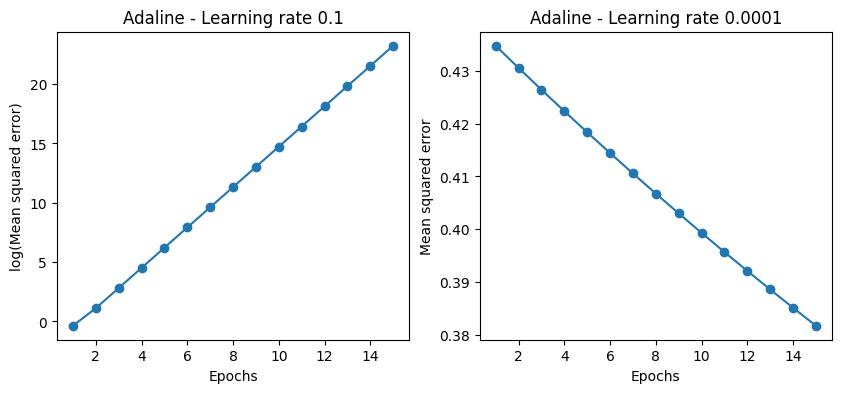

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ada1 = AdalineGD(n_iter=15, eta=0.1).fit(X, y)
ax[0].plot(range(1, len(ada1.losses_) + 1), np.log10(ada1.losses_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Mean squared error)')
ax[0].set_title('Adaline - Learning rate 0.1')

ada2 = AdalineGD(n_iter=15, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.losses_) + 1), ada2.losses_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Mean squared error')
ax[1].set_title('Adaline - Learning rate 0.0001')

plt.show()

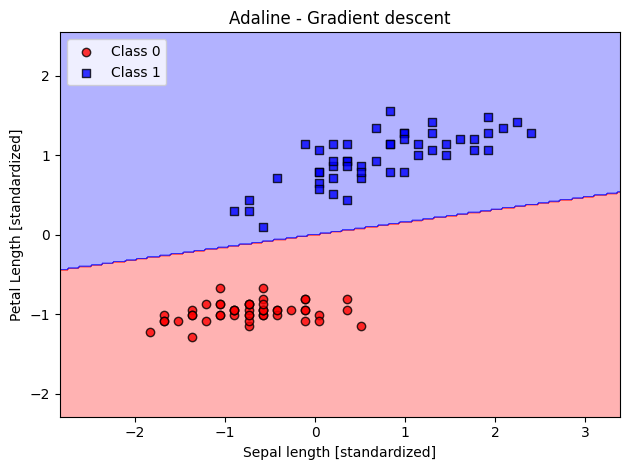

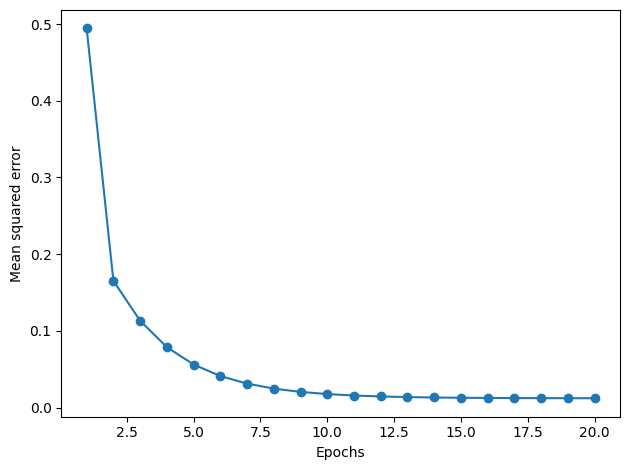

In [34]:
X_std = np.copy(X)
X_std[:,0] = (X[:,0] - X[:,0].mean()) / X[:,0].std()
X_std[:,1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()

ada_gd = AdalineGD(n_iter=20, eta=0.5)
ada_gd.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada_gd)
plt.title('Adaline - Gradient descent')
plt.xlabel('Sepal length [standardized]')
plt.ylabel('Petal Length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
plt.plot(range(1, len(ada_gd.losses_) +1), ada_gd.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.tight_layout()
plt.show()

In [41]:
### Adaline SGD ###

import numpy as np

class AdalineSGD:
    """ADAptive LInear NEuron classifier
    
    Parameters
    ----------
    eta : float
    Learning rate (0.0 to 1.0)

    n_iter : int
    epochs, or passes over training set

    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.

    random_state: int
    random number generator

    Attributes
    ----------

    w_ : 1d-array
    weights after fitting
    
    b_ : Scalar
    bias unit after fitting

    losses_ : list
    Mean squared error loss function values in each epoch.
    
    """
    def __init__ (self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state

    def fit(self, X, y):
        """
        Fit training data

        X : array-like, shape = [ n_examples, n_features ]
        n_examples - number of examples
        n_features - number of features

        y : shape = [ n_examples ]
        Target Values

        Returns
        --------

        self : object

        """
        self._initialize_weights(X.shape[1])
        self.losses_ = []

        for i in range (self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)

        return self
    
    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self
    
    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = np.float_(0.)
        self.w_initialized = True

    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = ( target - output)
        self.w_ += self.eta * 2.0 * xi * (error)
        self.b_ += self.eta * 2.0 * error
        loss = error**2
        return loss
    
    def net_input(self, X):
        """Caluclate net input"""
        return np.dot(X, self.w_) + self.b_
    
    def activation(self, X):
        """Compute linear activation"""
        return X
    
    def predict(self, X):
        """Return class label after unit steip"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

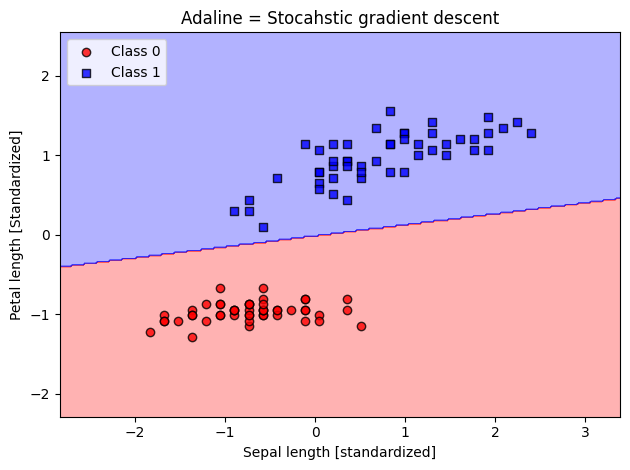

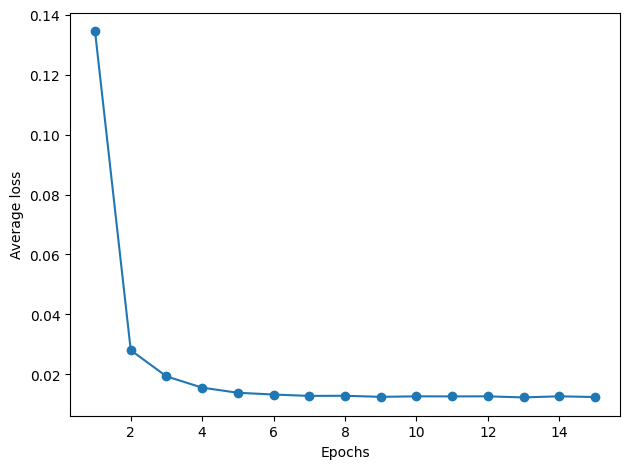

In [42]:
ada_sgd = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada_sgd.fit(X_std, y)
plot_decision_regions(X_std, y, classifier=ada_sgd)
plt.title('Adaline = Stocahstic gradient descent')
plt.xlabel('Sepal length [standardized]')
plt.ylabel('Petal length [Standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
plt.plot(range(1, len(ada_sgd.losses_) +1), ada_sgd.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average loss')
plt.tight_layout()
plt.show()